In [3]:
import pickle
import pandas as pd 
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Binarizer
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential, load_model 

2022-04-23 12:21:16.810285: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-23 12:21:16.810313: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
#For colab purpose only
#from google.colab import drive
#drive.mount('/content/drive')

# Data Preperation

In [5]:
# #Load lemmatizationed data as .pkl
#with open("/content/drive/MyDrive/data_lem.pkl", 'rb') as f:
#    data_lem = pickle.load(f)

#load original data set
#df = pd.read_json("https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json")

In [6]:
 #Load lemmatizationed data as .pkl
 #version for Zeno
with open("/home/valentin_werner/.local/bin/data_lem.pkl", 'rb') as f:
    data_lem = pickle.load(f)

#load original data set
df = pd.read_json("https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json")

In [7]:
#example data
data_lem[0]

'car wonder enlighten car see day door sport car look late early call bricklin door small addition bumper separate rest body know tellme model engine specs year production car history info funky looking car mail thank'

In [8]:
#looking at the data frame, we can see that our y to predict is "target"
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [9]:
#ckecking out the frequency of every label, looks pretty even
df.groupby("target").target.count()

target
0     480
1     584
2     591
3     590
4     578
5     593
6     585
7     594
8     598
9     597
10    600
11    595
12    591
13    594
14    593
15    599
16    546
17    564
18    465
19    377
Name: target, dtype: int64

In [10]:
#quick check if both lists have the same length, so no data was lost in the preprocessing
df.shape, len(data_lem)

((11314, 3), 11314)

In [11]:
#overwrite the unprocessed data in the df with the preprocessed and lemmatized data from earlier
df.content = data_lem

<AxesSubplot:xlabel='count', ylabel='target_names'>

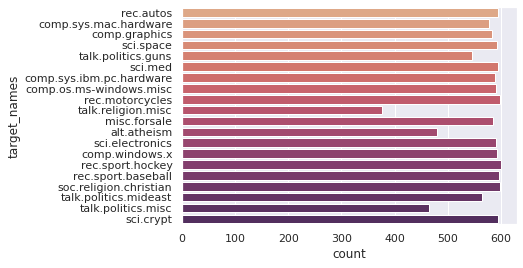

In [12]:
#plot a countplot of all the categories (similar to the groupby)
sns.set(font_scale = 1)
sns.countplot(y = "target_names", data = df, palette = "flare") 
#particularly on none-combined categories, the counts almost follow an uniform distribution, this is good for classification

In [13]:
#Train test split the data
X_train, X_test, y_train, y_test = train_test_split(df.content, df.target, test_size=0.15, random_state=1)

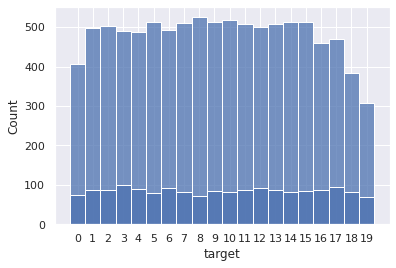

In [14]:
#Given that we have 20 classes that are almost equally distributed, lets look at the distribution of train and test
bins = np.arange(21) - 0.5
sns.histplot(y_train, bins = bins)
sns.histplot(y_test, bins = bins)
plt.xticks(np.arange(0,20));
#this actually will probably work out fine, but we can also stratify it, to have some better result (and learn how to do it)

In [15]:
#Lets stratify it
X_train, X_test, y_train, y_test = train_test_split(df.content, df.target, test_size=0.15, random_state=1, stratify = df.target)

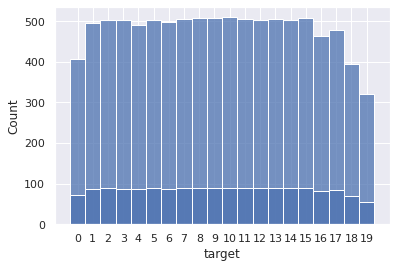

In [16]:
#Same plot but strafied train and test set
bins = np.arange(21) - 0.5
sns.histplot(y_train, bins = bins)
sns.histplot(y_test, bins = bins)
plt.xticks(np.arange(0,20));
#Better

In [17]:
#By using the tfidf vectorizer, we quantify our qualitative data and make it usable for ML
idf = TfidfVectorizer(max_df = 0.95, min_df = 0.01, smooth_idf = False)
#transform train and test data into vectors
x_train_idf = idf.fit_transform(X_train)
x_test_idf = idf.transform(X_test)

In [18]:
#example data from vectorized data
with np.printoptions(threshold=100):
    print(x_train_idf.toarray())
#worked :)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.13819172 ... 0.28866656 0.         0.        ]
 [0.17231783 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


# Naive Bayes

In [19]:
#First model: Multinomial (multi-class) NB
clf = MultinomialNB()
clf.fit(x_train_idf, y_train)
y_pred = clf.predict(x_test_idf)
accuracy_score(y_test, y_pred), accuracy_score(y_train, clf.predict(x_train_idf))
#the naive bayes can predict 77% of the unseen data correctly among 20 possible classifications!

(0.7703180212014135, 0.8493136439267887)

# Keras
can Keras perform better?

In [20]:
#This is needed for the Keras Input (doesnt like the sparse list)
x_train_idf = x_train_idf.toarray()
x_test_idf = x_test_idf.toarray()

In [21]:
#further split the train set into an actual train and a validation set
x_train_idf, x_val, y_train, y_val = train_test_split(x_train_idf, y_train, test_size=0.25, random_state=1, stratify = y_train)
#in result we now have 15% test, 21.25% validation, 63.75% train set
x_train_idf.shape

(7212, 1557)

In [22]:
#since we predict on 20 possible output classes, I want to binary encode the 20 possible 
#output values. In the hope to have cleaner learning when some outputs are very similar.
def get_dumm(num):
    arr = list(np.zeros(20, dtype='int8')) 
    arr[num] = 1 
    return arr

y_tr = np.array([get_dumm(y) for y in y_train])
y_val = np.array([get_dumm(y) for y in y_val])
y_te = np.array([get_dumm(y) for y in y_test])

In [23]:
#This function creates the keras model
def get_NN():
    """create NN"""
    #Architecture
    model = Sequential() 
    #Add Input Layer
    model.add(Dense(361, activation = "relu", input_shape = (x_train_idf.shape[1],)))
    #Add Hidden layers
    #for nodes in hidden layers I followed some of the guides on this post: https://www.researchgate.net/post/How-to-decide-the-number-of-hidden-layers-and-nodes-in-a-hidden-layer 
    #model.add(BatchNormalization())
    #model.add(Dropout(0.10))
    model.add(Dense(86, activation = "relu"))
    #Add Output layer 
    model.add(Dense(20, activation = "softmax"))
    return model

#This function plots a confusion matrix, train/val loss, train/val accuracy
def plot(fit, NN_preds):
    """return the final confusion matrix, loss plot and accuracy"""
    max_acc = max(fit.history["val_accuracy"])
    max_acc_index = fit.history["val_accuracy"].index(max_acc)
    print(f"best validation accuracy was found at {max_acc} on epoch {max_acc_index}")

    fig, ax = plt.subplots(1, 2, figsize = (30,8))
    #cm = confusion_matrix(y_test, NN_preds, labels=[0,1])
    #cm_matrix = pd.DataFrame(data=cm, columns=["Predicted: 0",'Predicted: 1'], index=['Actual:0','Actual:1'])
    #sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu', ax = ax[0])

    loss = fit.history["loss"]
    val_loss = fit.history["val_loss"]
    epochs = range(1, len(loss)+1)
    sns.lineplot(x = epochs, y = loss, color = "b", label = "Training loss", ax = ax[0])
    sns.lineplot(x = epochs, y = val_loss, color = "g", label = "Validation loss", ax = ax[0])

    train_acc = fit.history["accuracy"]
    val_acc = fit.history["val_accuracy"]
    sns.lineplot(x = epochs, y =train_acc, color = "b", label = "Training accuracy", ax = ax[1])
    sns.lineplot(x = epochs, y = val_acc, color = "g", label = "Validation accuracy", ax = ax[1])
    #also add a horizontal line at the maximum validation accuracy
    ax[1].axhline(max_acc, color = "r", label = f"Maximum validation Accuracy = {round(max_acc,3)}")
    plt.legend()

In [102]:
#Compiling
model = get_NN()
model.compile(loss = "categorical_crossentropy", optimizer = "SGD", metrics = ["accuracy"])

#Activate callbacks (so we dont lose our best model)
early_stop = EarlyStopping(patience = 30, monitor = "val_accuracy")
checkpoints =  ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

#Fit the model
fit = model.fit(x_train_idf, y_tr, validation_data = (x_val, y_val), epochs = 500, verbose = 1, batch_size = 128, callbacks = [early_stop, checkpoints])

Epoch 1/500
56/57 [============================>.] - ETA: 0s - loss: 2.9947 - accuracy: 0.0589
Epoch 1: val_accuracy improved from -inf to 0.05740, saving model to best_model.h5
57/57 [==============================] - 2s 19ms/step - loss: 2.9947 - accuracy: 0.0587 - val_loss: 2.9941 - val_accuracy: 0.0574
Epoch 2/500
57/57 [==============================] - ETA: 0s - loss: 2.9935 - accuracy: 0.0631
Epoch 2: val_accuracy improved from 0.05740 to 0.06240, saving model to best_model.h5
57/57 [==============================] - 1s 12ms/step - loss: 2.9935 - accuracy: 0.0631 - val_loss: 2.9930 - val_accuracy: 0.0624
Epoch 3/500
55/57 [===========================>..] - ETA: 0s - loss: 2.9923 - accuracy: 0.0679
Epoch 3: val_accuracy improved from 0.06240 to 0.07072, saving model to best_model.h5
57/57 [==============================] - 1s 12ms/step - loss: 2.9924 - accuracy: 0.0682 - val_loss: 2.9919 - val_accuracy: 0.0707
Epoch 4/500
57/57 [==============================] - ETA: 0s - loss: 2

best validation accuracy was found at 0.7762063145637512 on epoch 376
test accuracy from the best model found in fit: 0.7656065959952886


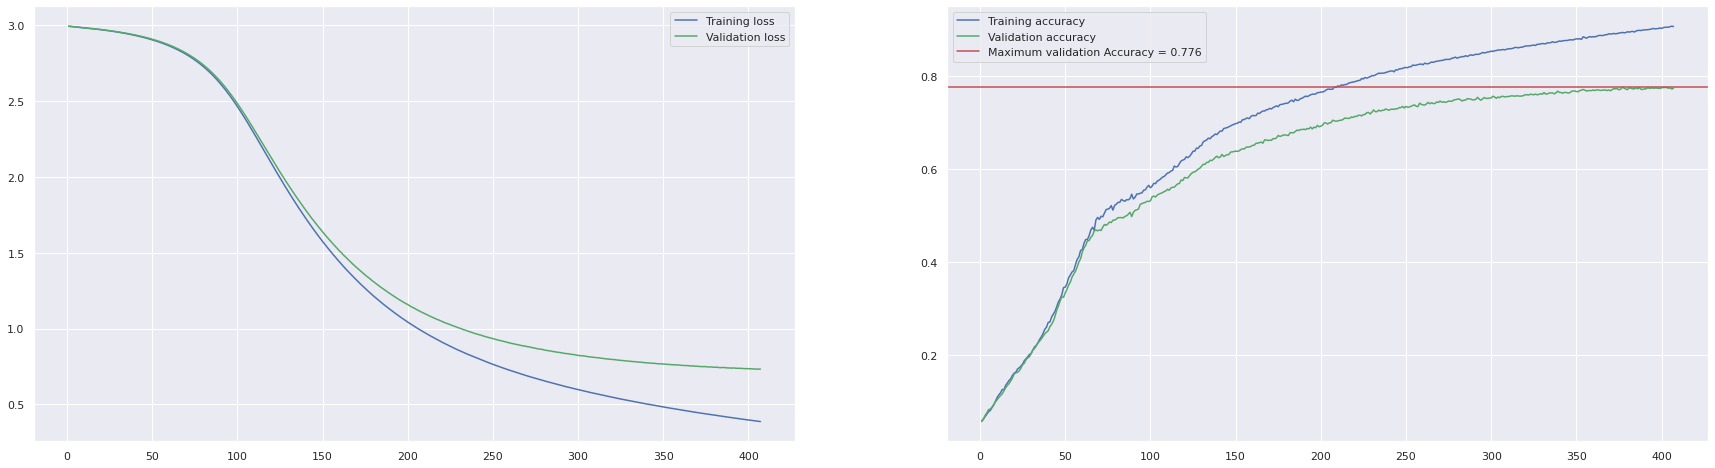

In [106]:
#Model evaluation
model2 = load_model("/content/best_model.h5")
preds = model2.predict(x_test_idf)
number_preds = [np.where(i == np.amax(i))[0][0] for i in preds]
plot(fit, preds)
print(f"test accuracy from the best model found in fit: {accuracy_score(y_test, number_preds)}")
#this model performs worse on the test set than the NB
#we can see in the loss curve, that this model learns very slow in the beginning

## Try 2
Since the first model was learning slow in the start, I put more Hidden Neurons; doubled the learning rate; reduced batch size and introduced Dropout to penalize the overfitting

This model yields 1% lower accuracy than the Naive Bayes

In [108]:
def get_NN():
    """create NN"""
    #Architecture
    model = Sequential() 
    #Add Input Layer
    model.add(Dense(450, activation = "relu", input_shape = (x_train_idf.shape[1],)))
    #Add Hidden layers
    #for nodes in hidden layers I followed some of the guides on this post: https://www.researchgate.net/post/How-to-decide-the-number-of-hidden-layers-and-nodes-in-a-hidden-layer 
    model.add(Dropout(0.20))
    model.add(Dense(125, activation = "relu"))
    #Add Output layer 
    model.add(Dense(20, activation = "softmax"))
    return model

In [109]:
#Compiling
model = get_NN()
opt = tf.keras.optimizers.SGD(learning_rate = 0.02) #(instead of 0.01)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
#Callbacks
early_stop = EarlyStopping(patience = 50, monitor = "val_accuracy")
checkpoints =  ModelCheckpoint('best_model2.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
#Fit
fit = model.fit(x_train_idf, y_tr, validation_data = (x_val, y_val), epochs = 500, verbose = 1, batch_size = 64, callbacks = [early_stop, checkpoints])

Epoch 1/500
112/113 [============================>.] - ETA: 0s - loss: 2.9963 - accuracy: 0.0476
Epoch 1: val_accuracy improved from -inf to 0.06448, saving model to best_model2.h5
113/113 [==============================] - 2s 12ms/step - loss: 2.9963 - accuracy: 0.0478 - val_loss: 2.9930 - val_accuracy: 0.0645
Epoch 2/500
113/113 [==============================] - ETA: 0s - loss: 2.9914 - accuracy: 0.0691
Epoch 2: val_accuracy improved from 0.06448 to 0.07571, saving model to best_model2.h5
113/113 [==============================] - 2s 20ms/step - loss: 2.9914 - accuracy: 0.0691 - val_loss: 2.9889 - val_accuracy: 0.0757
Epoch 3/500
112/113 [============================>.] - ETA: 0s - loss: 2.9872 - accuracy: 0.0857
Epoch 3: val_accuracy improved from 0.07571 to 0.09443, saving model to best_model2.h5
113/113 [==============================] - 2s 20ms/step - loss: 2.9872 - accuracy: 0.0857 - val_loss: 2.9848 - val_accuracy: 0.0944
Epoch 4/500
111/113 [============================>.] - 

best validation accuracy was found at 0.8074043393135071 on epoch 150
test accuracy from the best model found in fit: 0.7832744405182568


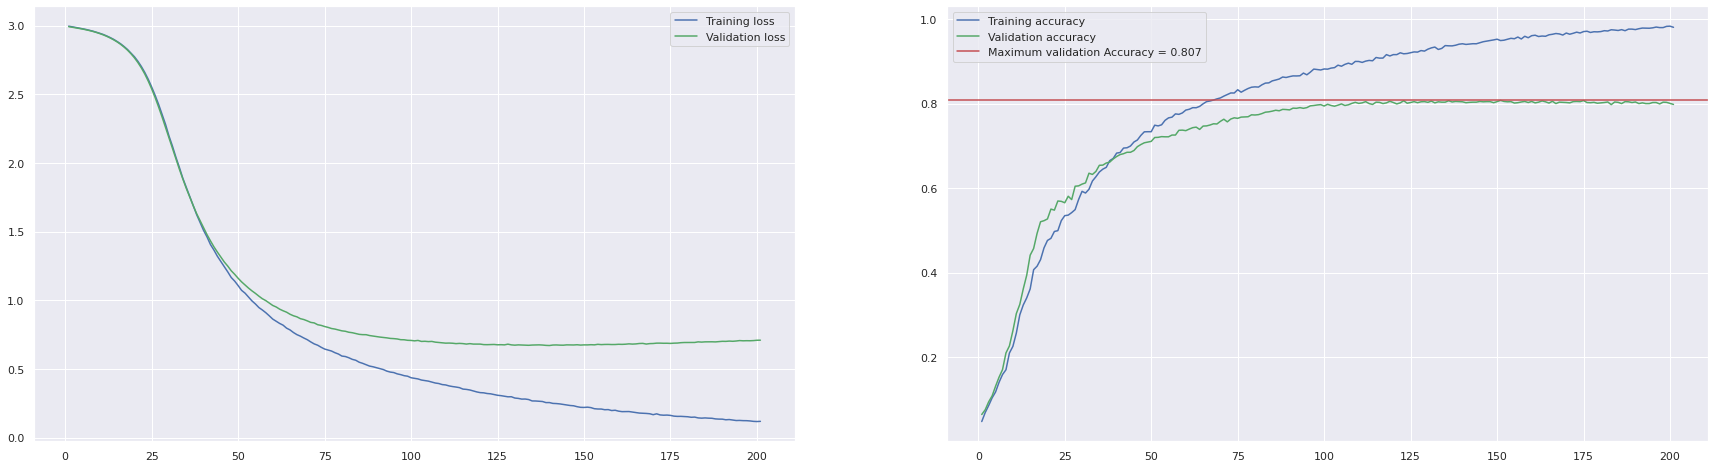

In [110]:
#Model evaluation
model2 = load_model("/content/best_model2.h5")
preds = model2.predict(x_test_idf)
number_preds = [np.where(i == np.amax(i))[0][0] for i in preds]
plot(fit, preds)
print(f"test accuracy from the best model found in fit: {accuracy_score(y_test, number_preds)}")
#this model learns faster in the start than before and peaks earlier than the other model
#validation accuracy improved a lot (77.6% -> 80.74)
#test accuracy improved a lot (76.6% -> 78.3%)

## Try 3
further increased dropout and added more hidden neurons (because it worked so well the first time)

In [111]:
def get_NN():
    """create NN"""
    #Architecture
    model = Sequential() 
    #Add Input Layer
    model.add(Dense(600, activation = "relu", input_shape = (x_train_idf.shape[1],)))
    #Add Hidden layers
    #for nodes in hidden layers I followed some of the guides on this post: https://www.researchgate.net/post/How-to-decide-the-number-of-hidden-layers-and-nodes-in-a-hidden-layer 
    model.add(Dropout(0.30))
    model.add(Dense(200, activation = "relu"))
    #Add Output layer 
    model.add(Dense(20, activation = "softmax"))
    return model

In [118]:
#Compiling
model = get_NN()
opt = tf.keras.optimizers.SGD(learning_rate = 0.02)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

early_stop = EarlyStopping(patience = 30, monitor = "val_accuracy")
checkpoints =  ModelCheckpoint('best_model3.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
fit = model.fit(x_train_idf, y_tr, validation_data = (x_val, y_val), epochs = 500, verbose = 1, batch_size = 64, callbacks = [early_stop, checkpoints])

Epoch 1/500
110/113 [============================>.] - ETA: 0s - loss: 2.9928 - accuracy: 0.0601
Epoch 1: val_accuracy improved from -inf to 0.07072, saving model to best_model3.h5
113/113 [==============================] - 2s 12ms/step - loss: 2.9928 - accuracy: 0.0598 - val_loss: 2.9904 - val_accuracy: 0.0707
Epoch 2/500
112/113 [============================>.] - ETA: 0s - loss: 2.9876 - accuracy: 0.0710
Epoch 2: val_accuracy improved from 0.07072 to 0.08777, saving model to best_model3.h5
113/113 [==============================] - 1s 10ms/step - loss: 2.9876 - accuracy: 0.0709 - val_loss: 2.9857 - val_accuracy: 0.0878
Epoch 3/500
108/113 [===========================>..] - ETA: 0s - loss: 2.9830 - accuracy: 0.0907
Epoch 3: val_accuracy improved from 0.08777 to 0.10940, saving model to best_model3.h5
113/113 [==============================] - 1s 10ms/step - loss: 2.9829 - accuracy: 0.0903 - val_loss: 2.9810 - val_accuracy: 0.1094
Epoch 4/500
111/113 [============================>.] - 

best validation accuracy was found at 0.8136439323425293 on epoch 171
test accuracy from the best model found in fit: 0.7897526501766784


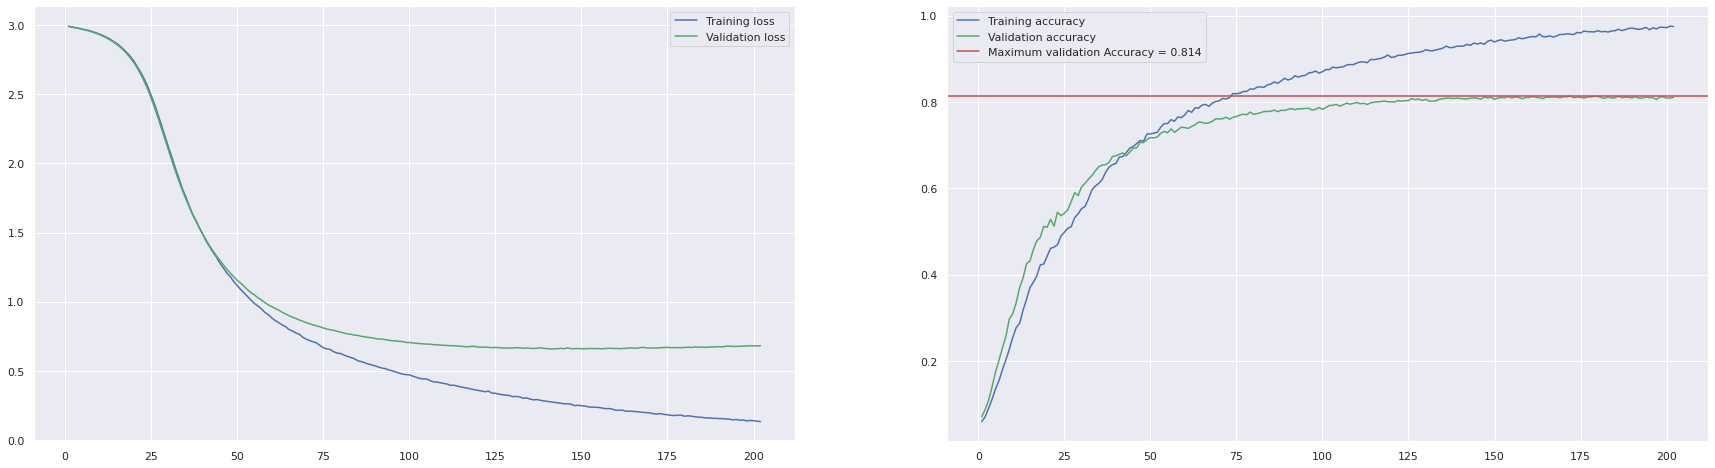

In [119]:
#Model evaluation
model2 = load_model("/content/best_model3.h5")
preds = model2.predict(x_test_idf)
number_preds = [np.where(i == np.amax(i))[0][0] for i in preds]
plot(fit, preds)
print(f"test accuracy from the best model found in fit: {accuracy_score(y_test, number_preds)}")
#this model learns faster in the start than before and peaks earlier than the other model
#validation accuracy increased a little (80.74% -> 81.36%)
#test accuracy increased a little (78.3% -> 79%)

## Try 4 
Reduce Neurons again, maintain dropout
Try different optimizer (Adam)

In [114]:
def get_NN():
    """create NN"""
    #Architecture
    model = Sequential() 
    #Add Input Layer
    model.add(Dense(450, activation = "relu", input_shape = (x_train_idf.shape[1],)))
    #Add Hidden layers
    #for nodes in hidden layers I followed some of the guides on this post: https://www.researchgate.net/post/How-to-decide-the-number-of-hidden-layers-and-nodes-in-a-hidden-layer 
    model.add(Dropout(0.30))
    model.add(Dense(125, activation = "relu"))
    #Add Output layer 
    model.add(Dense(20, activation = "softmax"))
    return model

In [121]:
#Compiling
model = get_NN()
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
#Callbacks
early_stop = EarlyStopping(patience = 50, monitor = "val_accuracy")
checkpoints =  ModelCheckpoint('best_model4.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
#fit
fit = model.fit(x_train_idf, y_tr, validation_data = (x_val, y_val), epochs = 500, verbose = 1, batch_size = 64, callbacks = [early_stop, checkpoints])

Epoch 1/500
113/113 [==============================] - ETA: 0s - loss: 2.1214 - accuracy: 0.5011
Epoch 1: val_accuracy improved from -inf to 0.74667, saving model to best_model4.h5
113/113 [==============================] - 2s 16ms/step - loss: 2.1214 - accuracy: 0.5011 - val_loss: 1.0126 - val_accuracy: 0.7467
Epoch 2/500
113/113 [==============================] - ETA: 0s - loss: 0.6877 - accuracy: 0.8142
Epoch 2: val_accuracy improved from 0.74667 to 0.78577, saving model to best_model4.h5
113/113 [==============================] - 1s 12ms/step - loss: 0.6877 - accuracy: 0.8142 - val_loss: 0.7039 - val_accuracy: 0.7858
Epoch 3/500
110/113 [============================>.] - ETA: 0s - loss: 0.3991 - accuracy: 0.8922
Epoch 3: val_accuracy improved from 0.78577 to 0.79908, saving model to best_model4.h5
113/113 [==============================] - 1s 12ms/step - loss: 0.4013 - accuracy: 0.8910 - val_loss: 0.6660 - val_accuracy: 0.7991
Epoch 4/500
108/113 [===========================>..] - 

best validation accuracy was found at 0.7995008230209351 on epoch 5
test accuracy from the best model found in fit: 0.7767962308598351


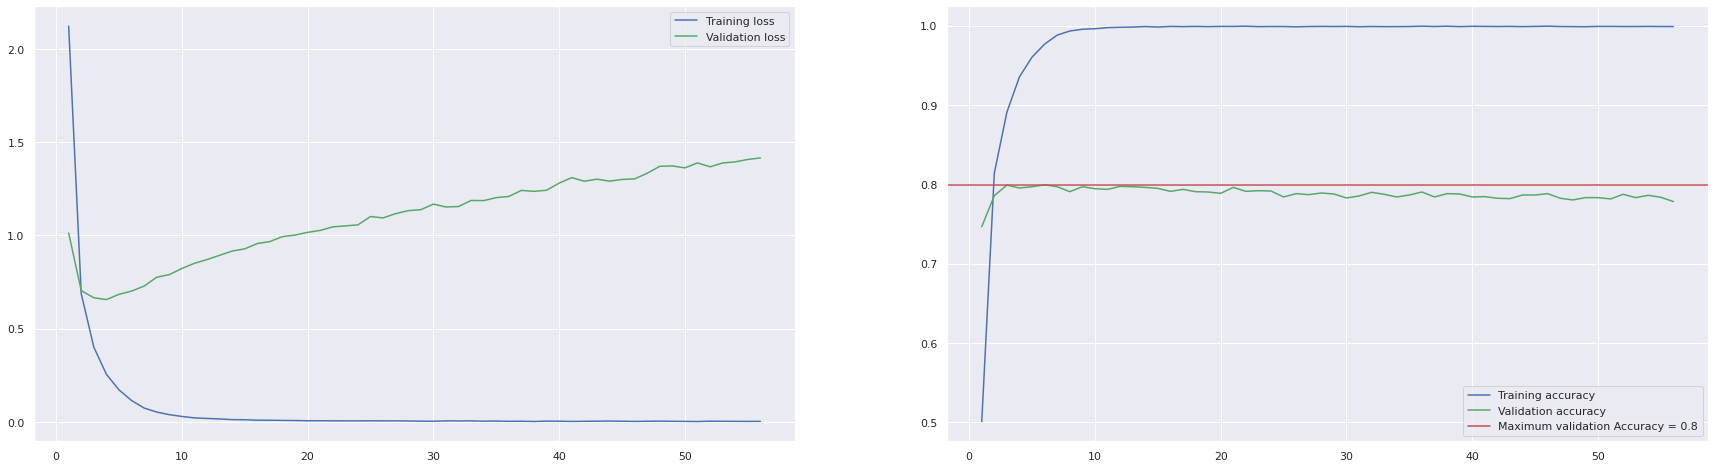

In [122]:
#Model evaluation
model2 = load_model("/content/best_model4.h5")
preds = model2.predict(x_test_idf)
number_preds = [np.where(i == np.amax(i))[0][0] for i in preds]
plot(fit, preds)
print(f"test accuracy from the best model found in fit: {accuracy_score(y_test, number_preds)}")
#this model learns faster but overfits very quick
#validation accuracy reduced (81.36% -> 79.95%)
#test accuracy improved a lot (79% -> 77.67%)

## Try 5
Seems like Adam is also a good optimizer, but overfits rather quick.
Lets reduce learning rate and neurons

In [124]:
def get_NN():
    """create NN"""
    #Architecture
    model = Sequential() 
    #Add Input Layer
    model.add(Dense(300, activation = "relu", input_shape = (x_train_idf.shape[1],)))
    #Add Hidden layers
    #for nodes in hidden layers I followed some of the guides on this post: https://www.researchgate.net/post/How-to-decide-the-number-of-hidden-layers-and-nodes-in-a-hidden-layer 
    model.add(Dropout(0.30))
    model.add(Dense(100, activation = "relu"))
    #Add Output layer 
    model.add(Dense(20, activation = "softmax"))
    return model

#Compiling
model = get_NN()
opt = tf.keras.optimizers.Adam(learning_rate = 0.001) #(0.1 -> 0.001)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
#Callbacks
early_stop = EarlyStopping(patience = 50, monitor = "val_accuracy")
checkpoints =  ModelCheckpoint('best_model5.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
#Fit
fit = model.fit(x_train_idf, y_tr, validation_data = (x_val, y_val), epochs = 500, verbose = 1, batch_size = 128, callbacks = [early_stop, checkpoints])

Epoch 1/500
55/57 [===========================>..] - ETA: 0s - loss: 2.7309 - accuracy: 0.3646
Epoch 1: val_accuracy improved from -inf to 0.68053, saving model to best_model5.h5
57/57 [==============================] - 2s 23ms/step - loss: 2.7151 - accuracy: 0.3717 - val_loss: 2.0201 - val_accuracy: 0.6805
Epoch 2/500
56/57 [============================>.] - ETA: 0s - loss: 1.3280 - accuracy: 0.7307
Epoch 2: val_accuracy improved from 0.68053 to 0.74667, saving model to best_model5.h5
57/57 [==============================] - 1s 13ms/step - loss: 1.3252 - accuracy: 0.7314 - val_loss: 0.9583 - val_accuracy: 0.7467
Epoch 3/500
56/57 [============================>.] - ETA: 0s - loss: 0.7062 - accuracy: 0.8145
Epoch 3: val_accuracy improved from 0.74667 to 0.78577, saving model to best_model5.h5
57/57 [==============================] - 1s 13ms/step - loss: 0.7066 - accuracy: 0.8141 - val_loss: 0.7504 - val_accuracy: 0.7858
Epoch 4/500
56/57 [============================>.] - ETA: 0s - loss

best validation accuracy was found at 0.808236300945282 on epoch 8
test accuracy from the best model found in fit: 0.790341578327444


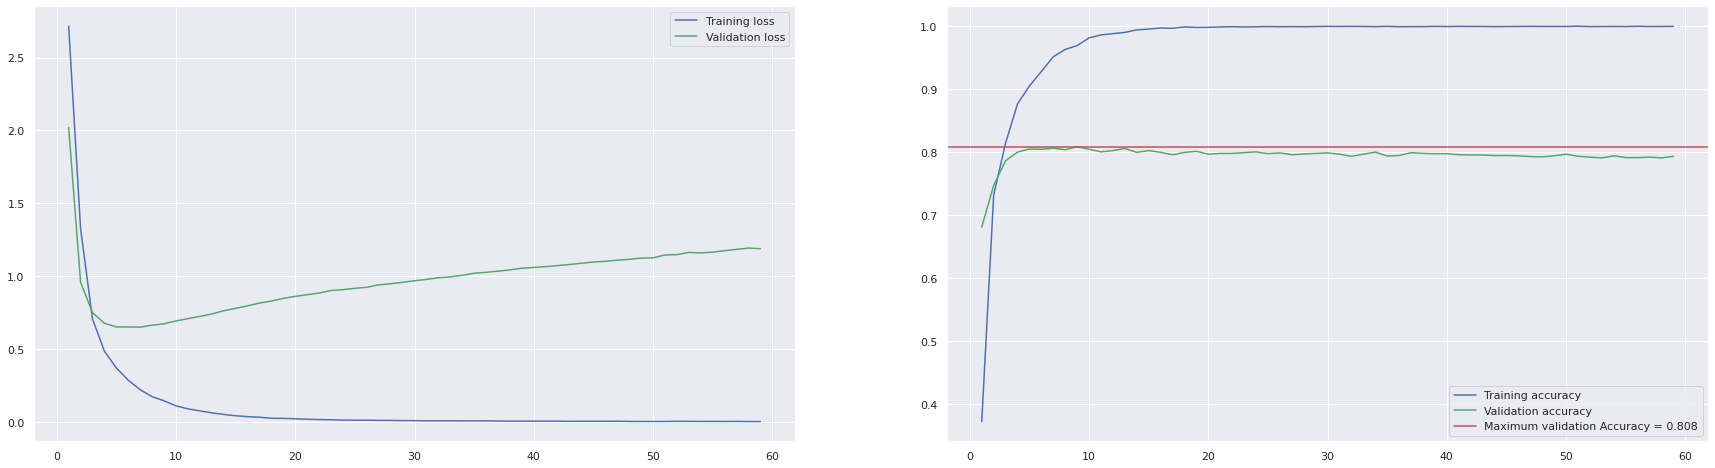

In [125]:
#Model evaluation
model2 = load_model("/content/best_model5.h5")
preds = model2.predict(x_test_idf)
number_preds = [np.where(i == np.amax(i))[0][0] for i in preds]
plot(fit, preds)
print(f"test accuracy from the best model found in fit: {accuracy_score(y_test, number_preds)}")
#this model learns a little slower but still overfits very quick
#validation accuracy increased (79.95% -> 80.8%)
#test accuracy increased a lot (77.67% -> 79%)

## Try 6 
Since reducing neurons also reduced accuracy, maybe increase it instead?
Also reduce learning rate further

In [126]:
def get_NN():
    """create NN"""
    #Architecture
    model = Sequential() 
    #Add Input Layer
    model.add(Dense(800, activation = "relu", input_shape = (x_train_idf.shape[1],)))
    #Add Hidden layers
    #for nodes in hidden layers I followed some of the guides on this post: https://www.researchgate.net/post/How-to-decide-the-number-of-hidden-layers-and-nodes-in-a-hidden-layer 
    model.add(Dropout(0.30))
    model.add(Dense(200, activation = "relu"))
    #Add Output layer 
    model.add(Dense(20, activation = "softmax"))
    return model

#Compiling
model = get_NN()
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001) #again divided by 10
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
#Callbacks
early_stop = EarlyStopping(patience = 50, monitor = "val_accuracy")
checkpoints =  ModelCheckpoint('best_model6.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
#Fit
fit = model.fit(x_train_idf, y_tr, validation_data = (x_val, y_val), epochs = 500, verbose = 1, batch_size = 128, callbacks = [early_stop, checkpoints])

Epoch 1/500
55/57 [===========================>..] - ETA: 0s - loss: 2.9790 - accuracy: 0.1403
Epoch 1: val_accuracy improved from -inf to 0.33985, saving model to best_model6.h5
57/57 [==============================] - 2s 30ms/step - loss: 2.9784 - accuracy: 0.1443 - val_loss: 2.9542 - val_accuracy: 0.3399
Epoch 2/500
57/57 [==============================] - ETA: 0s - loss: 2.9122 - accuracy: 0.3902
Epoch 2: val_accuracy improved from 0.33985 to 0.51830, saving model to best_model6.h5
57/57 [==============================] - 2s 28ms/step - loss: 2.9122 - accuracy: 0.3902 - val_loss: 2.8565 - val_accuracy: 0.5183
Epoch 3/500
55/57 [===========================>..] - ETA: 0s - loss: 2.7594 - accuracy: 0.5641
Epoch 3: val_accuracy improved from 0.51830 to 0.62063, saving model to best_model6.h5
57/57 [==============================] - 2s 28ms/step - loss: 2.7565 - accuracy: 0.5656 - val_loss: 2.6444 - val_accuracy: 0.6206
Epoch 4/500
56/57 [============================>.] - ETA: 0s - loss

best validation accuracy was found at 0.8115640878677368 on epoch 26
test accuracy from the best model found in fit: 0.7956419316843345


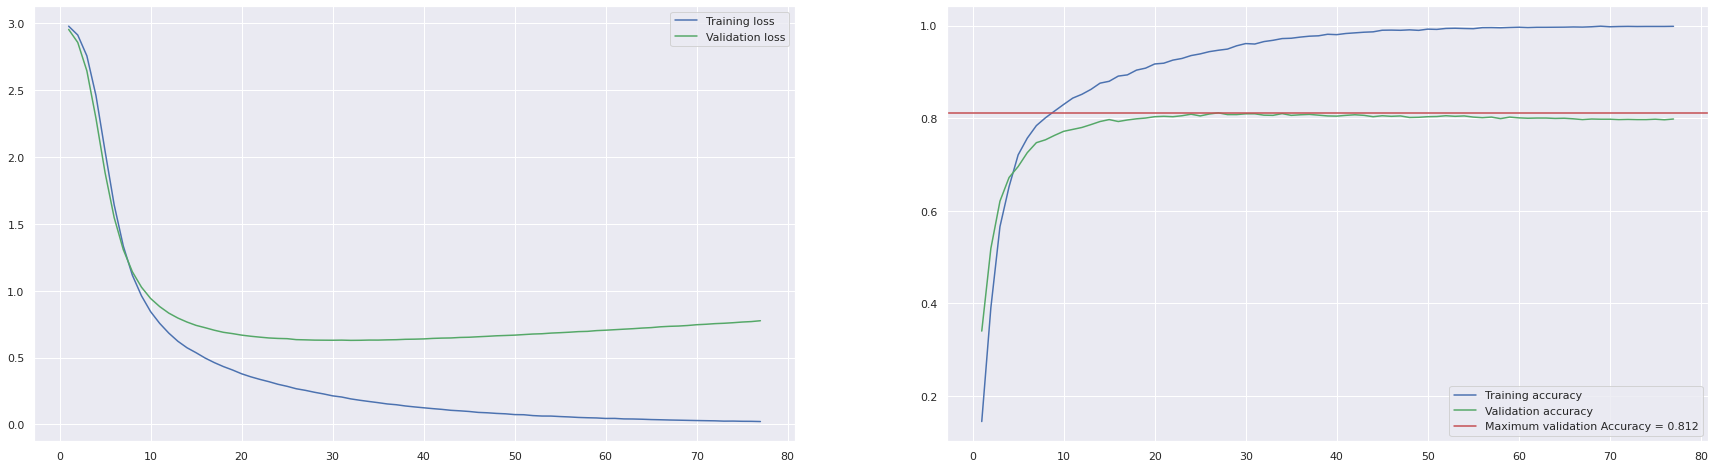

In [127]:
#Model evaluation
model2 = load_model("/content/best_model6.h5")
preds = model2.predict(x_test_idf)
number_preds = [np.where(i == np.amax(i))[0][0] for i in preds]
plot(fit, preds)
print(f"test accuracy from the best model found in fit: {accuracy_score(y_test, number_preds)}")
#this model learns a little slower but still overfits very quick
#validation accuracy increased (80.8% -> 81.16%)
#test accuracy increased (79%-> 79.56%)

##Try 7
Sometimes Batch Normalization can help with the accuracy

This also achieves a good validation accuracy at 80.2%. But given the train test curves, this model looks rather weird - also performing not better on the actual test set

In [128]:
def get_NN():
    """create NN"""
    #Architecture
    model = Sequential() 
    #Add Input Layer
    model.add(Dense(800, activation = "relu", input_shape = (x_train_idf.shape[1],)))
    #Add Hidden layers
    #for nodes in hidden layers I followed some of the guides on this post: https://www.researchgate.net/post/How-to-decide-the-number-of-hidden-layers-and-nodes-in-a-hidden-layer 
    model.add(BatchNormalization())
    model.add(Dropout(0.30))
    model.add(Dense(200, activation = "relu"))
    #Add Output layer 
    model.add(Dense(20, activation = "softmax"))
    return model

#Compiling
model = get_NN()
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
#Callbacks
early_stop = EarlyStopping(patience = 50, monitor = "val_accuracy")
checkpoints =  ModelCheckpoint('best_model7.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
#Fit
fit = model.fit(x_train_idf, y_tr, validation_data = (x_val, y_val), epochs = 500, verbose = 1, batch_size = 128, callbacks = [early_stop, checkpoints])

Epoch 1/500
56/57 [============================>.] - ETA: 0s - loss: 2.8004 - accuracy: 0.1723
Epoch 1: val_accuracy improved from -inf to 0.36439, saving model to best_model7.h5
57/57 [==============================] - 3s 33ms/step - loss: 2.7994 - accuracy: 0.1729 - val_loss: 2.9560 - val_accuracy: 0.3644
Epoch 2/500
57/57 [==============================] - ETA: 0s - loss: 2.0099 - accuracy: 0.5216
Epoch 2: val_accuracy improved from 0.36439 to 0.54908, saving model to best_model7.h5
57/57 [==============================] - 2s 35ms/step - loss: 2.0099 - accuracy: 0.5216 - val_loss: 2.8753 - val_accuracy: 0.5491
Epoch 3/500
56/57 [============================>.] - ETA: 0s - loss: 1.4281 - accuracy: 0.6994
Epoch 3: val_accuracy improved from 0.54908 to 0.66389, saving model to best_model7.h5
57/57 [==============================] - 3s 47ms/step - loss: 1.4284 - accuracy: 0.6990 - val_loss: 2.7430 - val_accuracy: 0.6639
Epoch 4/500
56/57 [============================>.] - ETA: 0s - loss

best validation accuracy was found at 0.8161397576332092 on epoch 31


0.797997644287397

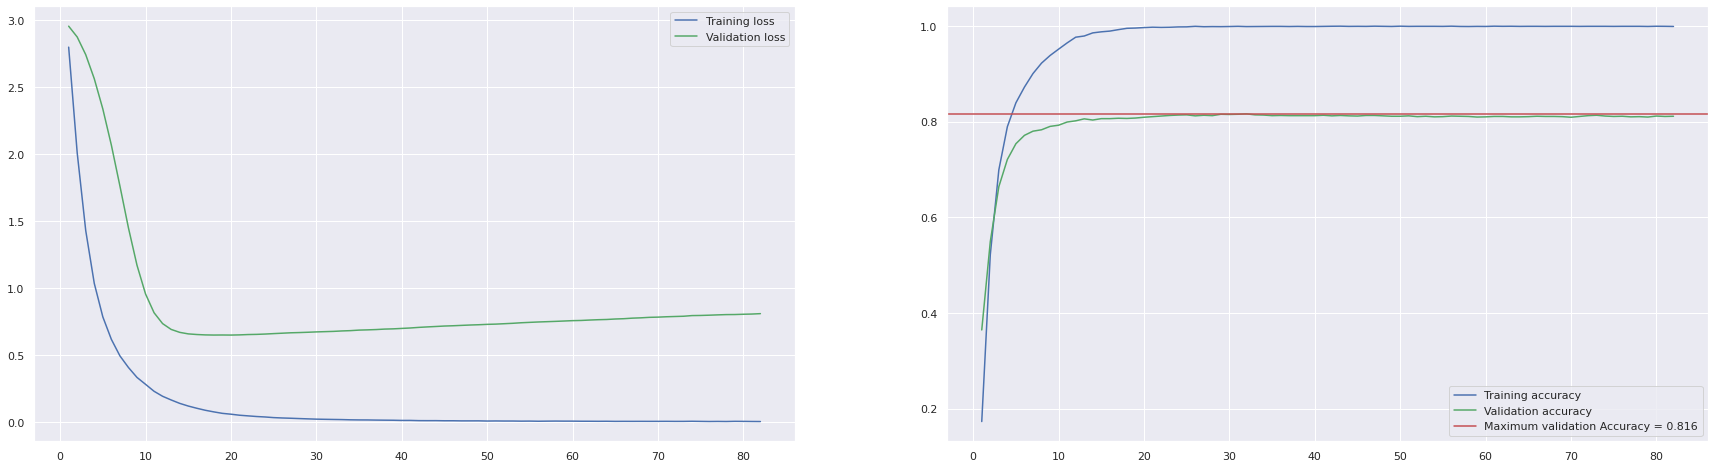

In [129]:
#Model evaluation
model2 = load_model("/content/best_model7.h5")
preds = model2.predict(x_test_idf)
number_preds = [np.where(i == np.amax(i))[0][0] for i in preds]
plot(fit, preds)
print(f"test accuracy from the best model found in fit: {accuracy_score(y_test, number_preds)}")
#this model learns a little slower but still overfits very quick
#validation accuracy increased (81.16% -> 81.61%)
#test accuracy increased (79.56% -> 79.8%)

#By normalizing the batches, the training loss is reduced faster.

# Trying the Keras Tuner as GridSearch

In [24]:
import keras_tuner as kt
#https://keras.io/guides/keras_tuner/getting_started/

In [25]:
def tuner_NN(hp):
  model = Sequential()
  layers = hp.Int("layers", 1,4)
  units = hp.Choice("units", [64, 128, 256, 512, 1024])
  batch_norm = hp.Boolean("batch_norm")
  dropout = hp.Boolean("dropout")
  for i in range(layers):
    if batch_norm:
      model.add(BatchNormalization())
    if dropout:
      model.add(Dropout(0.2))
    model.add(Dense(
      units = (units / (i+1)),
      activation="relu", 
      input_shape = (x_train_idf.shape[1],)))
  model.add(Dense(20, activation="softmax"))
  learning_rate = hp.Choice("lr", [0.1, 0.01, 0.001, 0.0001, 0.00001])
  opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
  model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
  return model

In [26]:
random = kt.RandomSearch(
    tuner_NN,
    objective="val_accuracy",
    max_trials = 10,
    executions_per_trial = 2)
random.search(x_train_idf, y_tr, validation_data = (x_val, y_val), epochs = 500, 
             callbacks = [EarlyStopping(patience = 25, monitor = "val_accuracy", restore_best_weights = True)])

best_hps=random.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n
Layers: {best_hps.get("layers")}  \n
Nodes in first layer (/2 for every following layer): {best_hps.get("units")} \n
Batch Normalization: {best_hps.get("batch_norm")} \n
Dropout: {best_hps.get("dropout")} \n
Learning Rate: {best_hps.get("lr")}
""")

Trial 31 Complete [00h 15m 40s]
val_accuracy: 0.792637288570404

Best val_accuracy So Far: 0.8223793804645538
Total elapsed time: 00h 15m 40s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 

Layers: 1  

Nodes in first layer (/2 for every following layer): 256 

Batch Normalization: False 

Dropout: True 

Learning Rate: 1e-05



In [37]:
# Get the optimal hyperparameters
opt_model = Sequential()
opt_model.add(Dropout(0.2))
opt_model.add(Dense(256, input_shape = (x_train_idf.shape[1],)))
opt_model.add(Dense(20, activation="softmax"))
opt = tf.keras.optimizers.Adam(learning_rate = 1e-05)
opt_model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

best_fit = opt_model.fit(x_train_idf, y_tr, 
                        validation_data = (x_val, y_val), 
                        epochs = 500, 
                        callbacks = EarlyStopping(patience = 25, monitor = "val_accuracy", restore_best_weights = True))

val_acc_per_epoch = best_fit.history['val_accuracy']
train_acc_per_epoch = best_fit.history["accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
predictions = opt_model.predict(x_test_idf)
print(f"Best epoch: {best_epoch} \nwith a validation accuracy of {max(val_acc_per_epoch)} \na train accuracy of {train_acc_per_epoch[best_epoch-1]} \nand a test accuracy of {accuracy_score(y_test, [np.where(i == np.amax(i))[0][0] for i in predictions])}")

Epoch 1/500
226/226 [==============================] - 1s 5ms/step - loss: 2.9936 - accuracy: 0.0520 - val_loss: 2.9876 - val_accuracy: 0.0790
Epoch 2/500
226/226 [==============================] - 1s 4ms/step - loss: 2.9787 - accuracy: 0.1027 - val_loss: 2.9739 - val_accuracy: 0.1314
Epoch 3/500
226/226 [==============================] - 1s 4ms/step - loss: 2.9644 - accuracy: 0.1669 - val_loss: 2.9602 - val_accuracy: 0.2005
Epoch 4/500
226/226 [==============================] - 1s 4ms/step - loss: 2.9491 - accuracy: 0.2345 - val_loss: 2.9464 - val_accuracy: 0.2750
Epoch 5/500
226/226 [==============================] - 1s 4ms/step - loss: 2.9336 - accuracy: 0.3085 - val_loss: 2.9324 - val_accuracy: 0.3428
Epoch 6/500
226/226 [==============================] - 1s 4ms/step - loss: 2.9190 - accuracy: 0.3697 - val_loss: 2.9184 - val_accuracy: 0.4018
Epoch 7/500
226/226 [==============================] - 1s 4ms/step - loss: 2.9032 - accuracy: 0.4226 - val_loss: 2.9041 - val_accuracy: 0.4443

## Keras Hyperband

In [ ]:
tuner = kt.Hyperband(
    tuner_NN,
    objective="val_accuracy",
    max_epochs= 50000,
    factor = 500,
    hyperband_iterations = 3,
    overwrite = True)
tuner.search(x_train_idf, y_tr, validation_data = (x_val, y_val), epochs = 500, 
             callbacks = [EarlyStopping(patience = 25, monitor = "val_accuracy", restore_best_weights = True)])

#best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n
Layers: {best_hps.get("layers")}  \n
Nodes in first layer (/2 for every following layer): {best_hps.get("units")} \n
Batch Normalization: {best_hps.get("batch_norm")} \n
Dropout: {best_hps.get("dropout")} \n
Learning Rate: {best_hps.get("lr")}
""")

# Different data split

In [56]:
#Train test split the data
X_train, X_test, y_train, y_test = train_test_split(df.content, df.target, test_size=0.15, random_state=1)
#By using the tfidf vectorizer, we quantify our qualitative data and make it usable for ML
idf = TfidfVectorizer(max_df = 0.95, min_df = 0.001, smooth_idf = False) #reducing min_df
#transform train and test data into vectors
x_train_idf = idf.fit_transform(X_train).toarray()
x_test_idf = idf.transform(X_test).toarray()

x_train_new, x_val_new, y_train_new, y_val_new = train_test_split(x_train_idf, y_train, test_size=0.25, random_state=1, stratify = y_train)

#since we predict on 20 possible output classes, I want to binary encode the 20 possible 
#output values. In the hope to have cleaner learning when some outputs are very similar.
def get_dumm(num):
    arr = list(np.zeros(20, dtype='int8')) 
    arr[num] = 1 
    return arr

y_tr_new = np.array([get_dumm(y) for y in y_train_new])
y_val_new = np.array([get_dumm(y) for y in y_val_new])
y_te = np.array([get_dumm(y) for y in y_test])

In [61]:
nb_new = MultinomialNB()
nb_new.fit(x_train_new, y_train_new)
print(f"test accuracy: {accuracy_score(y_test, nb_new.predict(x_test_idf))} \n train accuracy: {accuracy_score(y_train_new, nb_new.predict(x_train_new))}")

test accuracy: 0.8439340400471143 
 train accuracy: 0.9305324459234608


In [49]:
def tuner_new(hp):
  model = Sequential()
  layers = hp.Int("layers", 1,4)
  units = hp.Choice("units", [64, 128, 256, 512, 1024])
  batch_norm = hp.Boolean("batch_norm")
  dropout = hp.Boolean("dropout")
  for i in range(layers):
    if batch_norm:
      model.add(BatchNormalization())
    if dropout:
      model.add(Dropout(0.2))
    model.add(Dense(
      units = (units / (i+1)),
      activation="relu", 
      input_shape = (x_train_idf.shape[1],)))
  model.add(Dense(20, activation="softmax"))
  learning_rate = hp.Choice("lr", [0.1, 0.01, 0.001, 0.0001, 0.00001])
  opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
  model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
  return model

In [53]:
#just run for 5 trias as "taste" of dimension
#(likely none of these 5 models will be optimal)
new_data = kt.RandomSearch(
    tuner_new,
    objective="val_accuracy",
    max_trials = 5,
    executions_per_trial = 2,
    project_name = "new_data")
new_data.search(x_train_new, y_tr_new, validation_data = (x_val_new, y_val_new), epochs = 500, 
             callbacks = [EarlyStopping(patience = 10, monitor = "val_accuracy", restore_best_weights = True)])

best_hps=new_data.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n
Layers: {best_hps.get("layers")}  \n
Nodes in first layer (/2 for every following layer): {best_hps.get("units")} \n
Batch Normalization: {best_hps.get("batch_norm")} \n
Dropout: {best_hps.get("dropout")} \n
Learning Rate: {best_hps.get("lr")}""")
#this data is obviously way more suited to do this prediction.

Trial 5 Complete [00h 00m 46s]
val_accuracy: 0.2223377749323845

Best val_accuracy So Far: 0.904118150472641
Total elapsed time: 00h 21m 35s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 

Layers: 1  

Nodes in first layer (/2 for every following layer): 1024 

Batch Normalization: True 

Dropout: True 

Learning Rate: 1e-05


Epoch 1/500
226/226 [==============================] - 7s 29ms/step - loss: 2.7541 - accuracy: 0.2126 - val_loss: 2.8851 - val_accuracy: 0.4817
Epoch 2/500
226/226 [==============================] - 6s 28ms/step - loss: 2.1270 - accuracy: 0.6016 - val_loss: 2.4116 - val_accuracy: 0.7097
Epoch 3/500
226/226 [==============================] - 6s 28ms/step - loss: 1.6712 - accuracy: 0.7700 - val_loss: 1.4981 - val_accuracy: 0.7908
Epoch 4/500
226/226 [==============================] - 6s 28ms/step - loss: 1.3459 - accuracy: 0.8361 - val_loss: 1.0094 - val_accuracy: 0.8215
Epoch 5/500
226/226 [==============================] - 6s 28ms/step - loss: 1.1198 - accuracy: 0.8692 - val_loss: 0.8142 - val_accuracy: 0.8415
Epoch 6/500
226/226 [==============================] - 6s 28ms/step - loss: 0.9499 - accuracy: 0.8913 - val_loss: 0.7016 - val_accuracy: 0.8532
Epoch 7/500
226/226 [==============================] - 6s 27ms/step - loss: 0.8241 - accuracy: 0.9054 - val_loss: 0.6214 - val_accuracy:

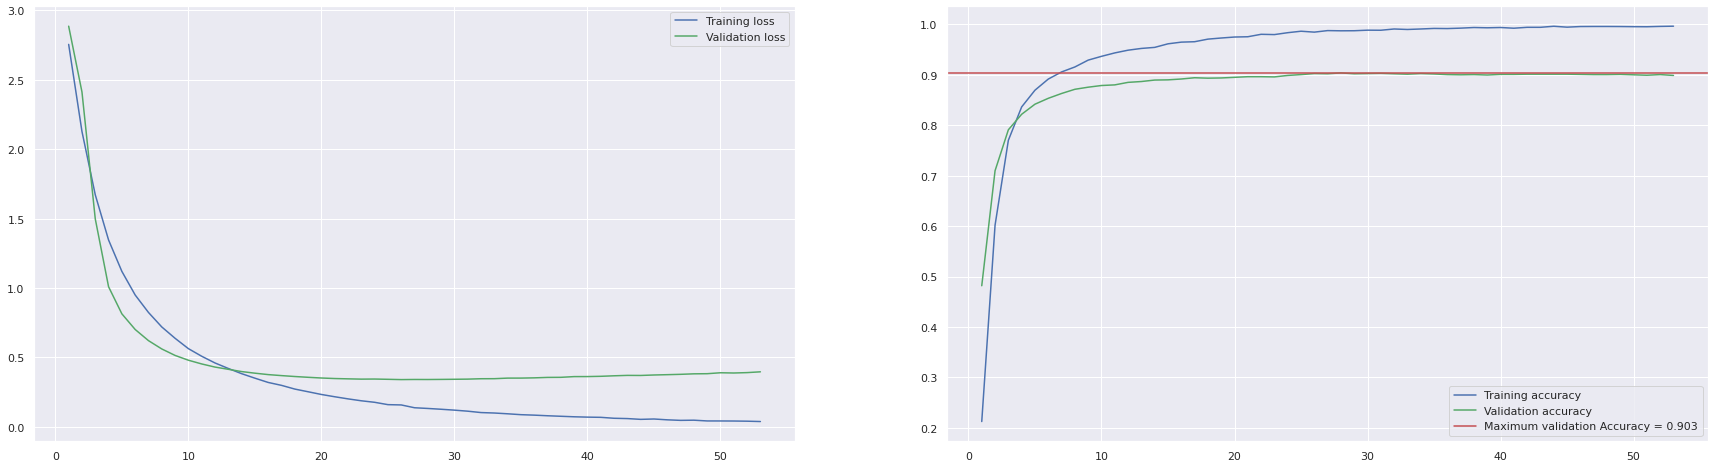

In [64]:
# Get the optimal hyperparameters
opt_model = Sequential()
opt_model.add(Dropout(0.2))
opt_model.add(BatchNormalization())
opt_model.add(Dense(1024, input_shape = (x_train_new.shape[1],)))
opt_model.add(Dense(20, activation="softmax"))
opt = tf.keras.optimizers.Adam(learning_rate = 1e-05)
opt_model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

best_fit = opt_model.fit(x_train_new, y_tr_new, 
                        validation_data = (x_val_new, y_val_new), 
                        epochs = 500, 
                        callbacks = EarlyStopping(patience = 25, monitor = "val_accuracy", restore_best_weights = True))

preds = opt_model.predict(x_test_idf)
number_preds = [np.where(i == np.amax(i))[0][0] for i in preds]
plot(best_fit, preds)
print(f"test accuracy from the best model found in fit: {accuracy_score(y_test, number_preds)}")
#looks decent :)